In [1]:
# # Create data folder and download data
!cd "/content"; mkdir "data"; cd "/content/data" ; gdown "16fYQr2SJDMK_SjPWSd4uYo03-hwW74M2"

Downloading...
From (original): https://drive.google.com/uc?id=16fYQr2SJDMK_SjPWSd4uYo03-hwW74M2
From (redirected): https://drive.google.com/uc?id=16fYQr2SJDMK_SjPWSd4uYo03-hwW74M2&confirm=t&uuid=d72e06eb-635c-49da-a5c0-14b329c7df1c
To: /content/data/icml_face_data.csv
100% 301M/301M [00:06<00:00, 43.5MB/s]


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split

In [3]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [4]:
df = pd.read_csv("./data/icml_face_data.csv")
images, labels = parse_data(df)

In [5]:
class EmotionDataset(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = ToTensor()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.transform(self.images[idx]).float(), self.labels[idx]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
training_dataloader = DataLoader(EmotionDataset(X_train, y_train), batch_size=1024, shuffle=True)
validation_dataloader = DataLoader(EmotionDataset(X_valid, y_valid), batch_size=1024, shuffle=True)
test_dataloader = DataLoader(EmotionDataset(X_test, y_test), batch_size=1024, shuffle=True)

In [10]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 1), nn.ELU(), nn.BatchNorm2d(64), #64x48x48
            nn.Conv2d(64, 64, 3), nn.ELU(), nn.BatchNorm2d(64),#64x46x46
            nn.Conv2d(64, 4, 3), nn.ELU(), nn.BatchNorm2d(4),  #4x44x44
            nn.Conv2d(4, 4, 3), nn.ELU(), nn.BatchNorm2d(4),  #4x42x42
        )
        self.flattern = nn.Flatten()
        self.linear1 = nn.Linear(4*42*42, 256)
        self.linear2 = nn.Linear(256, 4*42*42)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 4, 3), nn.ELU(), nn.BatchNorm2d(4),
            nn.ConvTranspose2d(4, 64, 3), nn.ELU(), nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, 3), nn.ELU(), nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 1), nn.ELU(),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flattern(x)
        x = self.linear1(x)
        return x

    def decode(self, x):
        x = self.linear2(x)
        x = x.reshape(-1, 4, 42, 42)
        x = self.decoder(x)
        return x

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    validation_loss = 0
    for inputs, labels in training_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        training_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item()
    print(f"Epoch {epoch+1:>2d}/{n_epochs}, Training Loss: {training_loss/len(training_dataloader):>5.6f}, Validation Loss: {validation_loss/len(validation_dataloader):5.6f}")

Epoch  1/50, Training Loss: 17347.990701, Validation Loss: 15199.784831
Epoch  2/50, Training Loss: 15702.156929, Validation Loss: 15446.164225
Epoch  3/50, Training Loss: 14968.808806, Validation Loss: 15390.044596
Epoch  4/50, Training Loss: 14353.398395, Validation Loss: 14137.986003
Epoch  5/50, Training Loss: 13758.965735, Validation Loss: 13249.124512
Epoch  6/50, Training Loss: 13143.662661, Validation Loss: 12532.265462
Epoch  7/50, Training Loss: 12557.234290, Validation Loss: 12098.081055
Epoch  8/50, Training Loss: 11924.214589, Validation Loss: 11693.486654
Epoch  9/50, Training Loss: 11337.714079, Validation Loss: 11022.132650
Epoch 10/50, Training Loss: 10746.454102, Validation Loss: 10111.923177
Epoch 11/50, Training Loss: 10156.310165, Validation Loss: 10125.530436
Epoch 12/50, Training Loss: 9547.381326, Validation Loss: 8891.417155
Epoch 13/50, Training Loss: 8982.307023, Validation Loss: 8450.534017
Epoch 14/50, Training Loss: 8395.469896, Validation Loss: 8155.73616

In [17]:
testing_data[0][0]

tensor([[[142., 148., 152.,  ...,  90.,  90.,  93.],
         [142., 147., 151.,  ...,  85.,  92., 103.],
         [141., 145., 151.,  ...,  86.,  82.,  95.],
         ...,
         [ 16.,  21.,  18.,  ...,  21.,  23.,  29.],
         [ 14.,  16.,  14.,  ...,  19.,  20.,  25.],
         [ 12.,  12.,  12.,  ...,  17.,  19.,  24.]]])

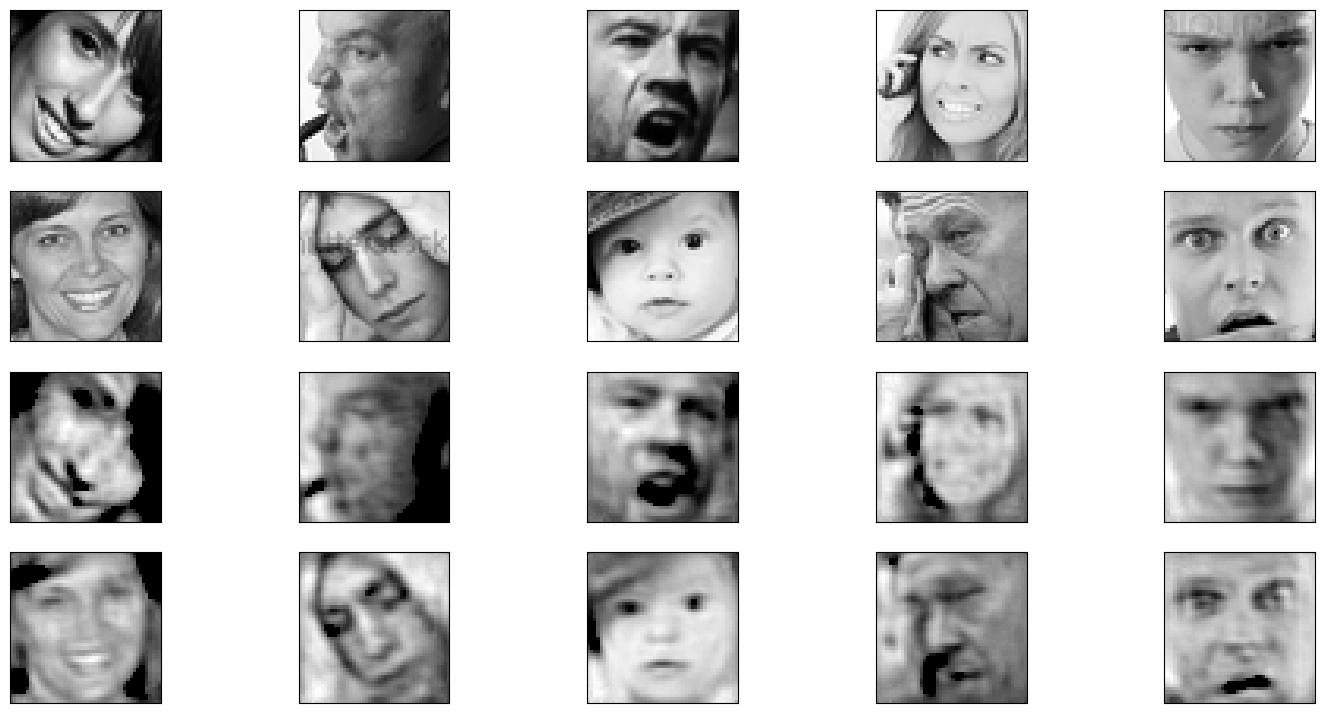

In [16]:
testing_data = EmotionDataset(X_test, y_test)
model.eval()
def show_img_with_model():
    _, axarr=plt.subplots(nrows=4, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    idxs = []
    for item in range(10):
        idxs.append(np.random.randint(0, len(testing_data)))
    for idx in range(10):
        image, label = testing_data[idxs[idx]]
        axarr[idx].imshow(image[0], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])

    for idx in range(10, 20):
        with torch.no_grad():
            image, label = testing_data[idxs[idx-10]]
            image = image.unsqueeze(0).to(device)
            generated_image = model(image).cpu()
            generated_image = generated_image.squeeze()
            axarr[idx].imshow(generated_image, cmap='gray')
            axarr[idx].set_xticks([])
            axarr[idx].set_yticks([])
show_img_with_model()

In [13]:
torch.save(model.state_dict(), "autoencoder_model_256.pth")

In [14]:
features_extraction_model = AutoEncoder()#.to(device)
features_extraction_model.load_state_dict(torch.load("/content/autoencoder_model_256.pth", map_location=torch.device('cpu')))
features_extraction_model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ELU(alpha=1.0)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
    (10): ELU(alpha=1.0)
    (11): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (flattern): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=7056, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=7056, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
  

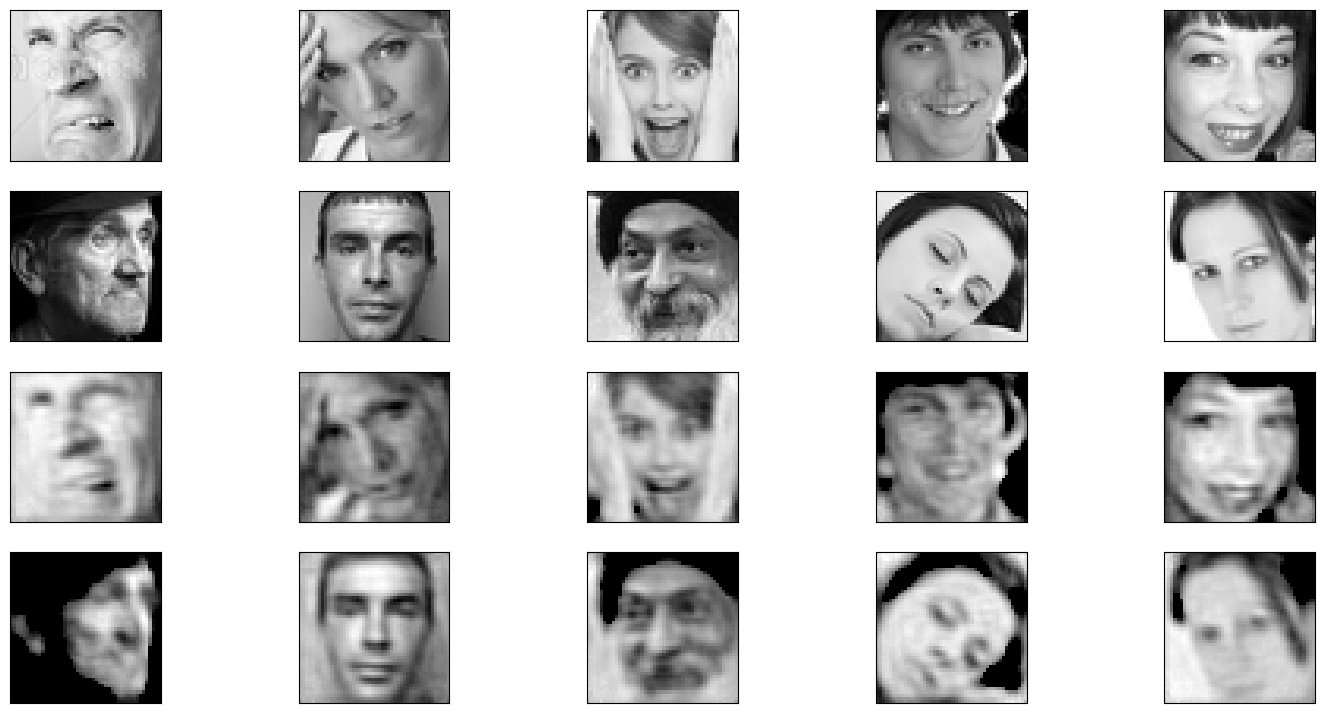

In [15]:
def show_img_with_model():
    _, axarr=plt.subplots(nrows=4, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    idxs = []
    for item in range(10):
        idxs.append(np.random.randint(0, len(testing_data)))
    for idx in range(10):
        image, label = testing_data[idxs[idx]]
        axarr[idx].imshow(image[0], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])

    for idx in range(10, 20):
        with torch.no_grad():
            image, label = testing_data[idxs[idx-10]]
            image = image.unsqueeze(0)#.to(device)
            generated_image = features_extraction_model(image).cpu()
            generated_image = generated_image.squeeze()
            axarr[idx].imshow(generated_image, cmap='gray')
            axarr[idx].set_xticks([])
            axarr[idx].set_yticks([])
show_img_with_model()

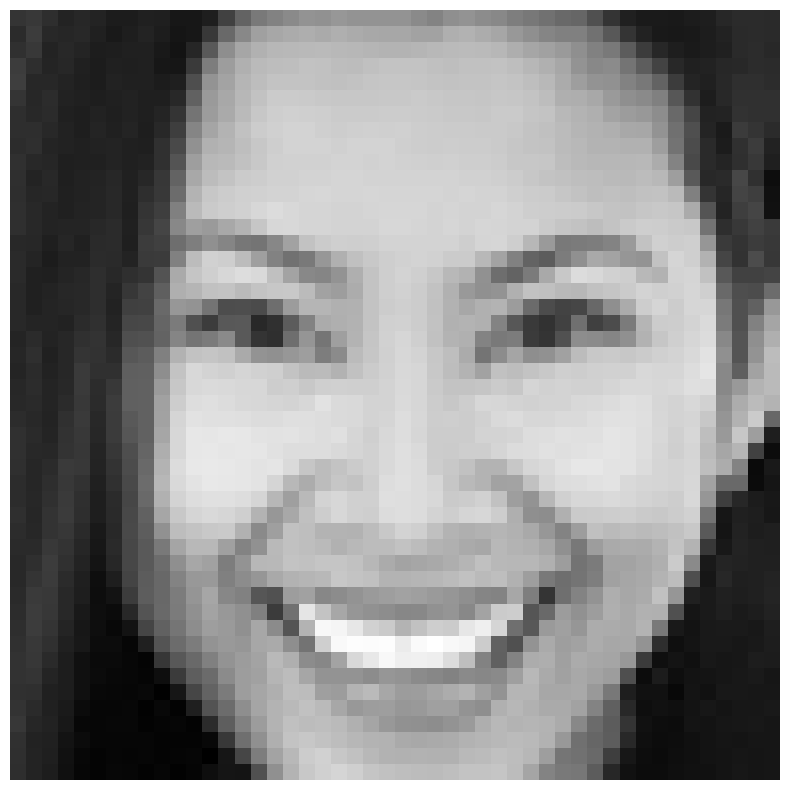

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(testing_data[1][0][0, :, :], cmap='gray')
ax.axis('off')
plt.show()
fig.savefig('input.png')

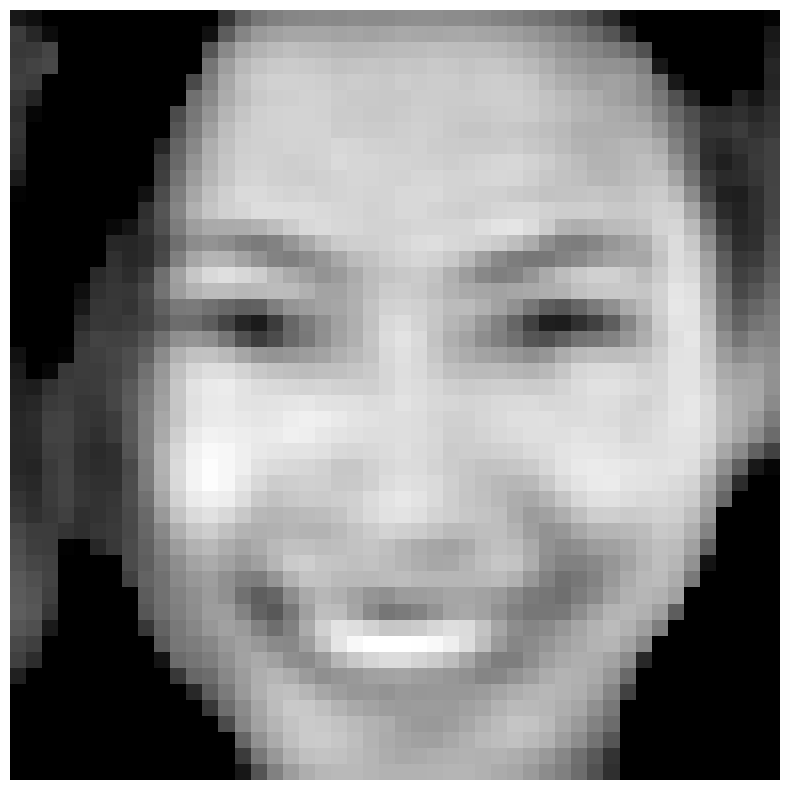

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
image = testing_data[1][0]
image = image.unsqueeze(0)#.to(device)
generated_image = features_extraction_model(image).cpu()
generated_image = generated_image.squeeze()
ax.imshow(generated_image.detach().numpy(), cmap='gray')
ax.axis('off')
plt.show()
fig.savefig('output.png')